# Visualization of r-band photometry data for supernova SN2011fe

In [37]:
# import relevant python libraries
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
from JSON_to_DF import JSON_to_DataFrame
%matplotlib notebook

In [42]:
# open and load the data 
source = open("../../../OSN_data/SN2011fe.json")
json_data = json.load(source)

#limit JSON data to just photometry elements
photo_data = json_data['SN2011fe']['photometry']

In [43]:
#Define the function used to model the data
def FitFunc_(t, A, B, t_0, t_1, Tfall, Trise):
	first = A * (1 + (B * (t - t_1)*(t - t_1)))
	var = -(t - t_0)
	second = np.exp(var / Tfall)
	third = 1 + np.exp(var / Trise)
	return first * (second / third)

In [44]:
#Create dictionaries to hold priors for model
priors = {
            'R' : [50, 20, 20, 50, 50, 50],
            'g' : [40,20,10,40,1,100],
            'I' : [100, 20, 20, 50, 50, 50]
          }
param_bounds = ([10*-5,10*-5,0,0,0,0], [1000,100,100,100,100,100])

In [45]:
#define conversion functions
def mag_to_flux(array):
    return 10**(-2*array / 5) 

def mag_err_to_flux_err(mags, errors, flux):
    mag_max = mags + errors
    flux_max = mag_to_flux(mag_max)
    flux_errors = flux_max - flux
    return flux_errors

<IPython.core.display.Javascript object>


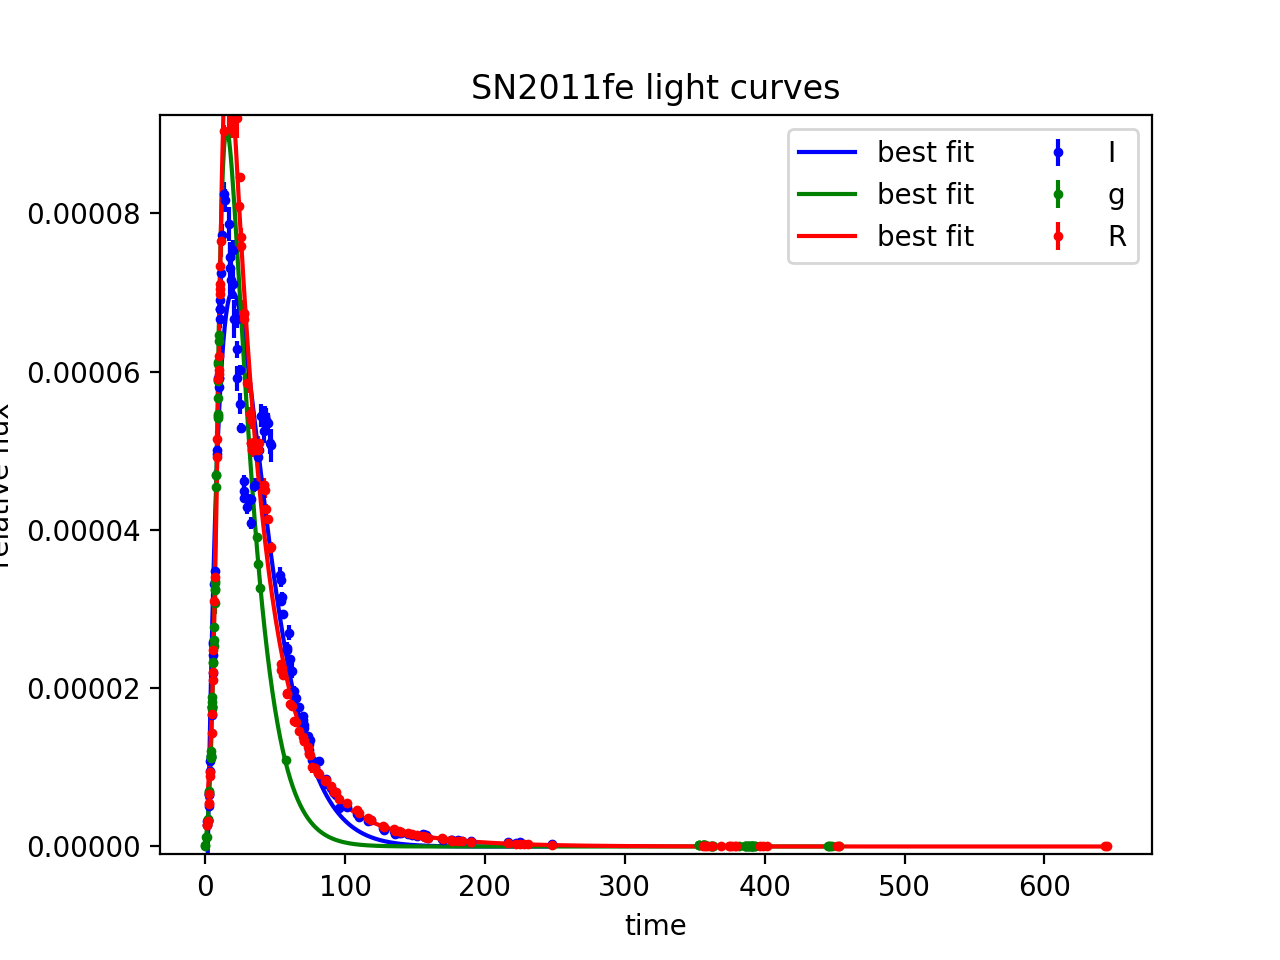

In [47]:
#create arrays to hold the time and corresponding magnitude and error for each band
R_data = []
g_data = []
I_data = []

magnitudes_R = []
mag_errors_R = []
times_R = []

magnitudes_g = []
mag_errors_g = []
times_g = []

magnitudes_I = []
mag_errors_I = []
times_I = []

#create dictionary to make looping easier
data = {

    'R' : [R_data, magnitudes_R, mag_errors_R, times_R],
    'I' : [I_data, magnitudes_I, mag_errors_I, times_I],
    'g' : [g_data, magnitudes_g, mag_errors_g, times_g]
}

for color in data:
    for x in range(len(photo_data) - 1):
        if('band' in photo_data[x] and photo_data[x]['band'] == color and 'upperlimit' not in photo_data[x]):
            data[color][0].append(photo_data[x])



#populate the arrays
for color in data:
    for x in data[color][0]:
        data[color][1].append(float(x['magnitude']))
        if(color == 'g'):
            data[color][2].append(float(x['e_upper_magnitude']))
        else:
            data[color][2].append(float(x['e_magnitude']))
        data[color][3].append(float(x['time']))

times_I = np.array(times_I)
times_g = np.array(times_g)
times_R = np.array(times_R)

magnitudes_I = np.array(magnitudes_I)
magnitudes_g = np.array(magnitudes_g)
magnitudes_R = np.array(magnitudes_R)

mag_errors_I = np.array(mag_errors_I)
mag_errors_g = np.array(mag_errors_g)
mag_errors_R = np.array(mag_errors_R)





#convert magnitudes to flux
flux_I = mag_to_flux(magnitudes_I)
flux_g = mag_to_flux(magnitudes_g)
flux_R = mag_to_flux(magnitudes_R)
#convert magnitude errors to flux errors
flux_errors_I = mag_err_to_flux_err(magnitudes_I, mag_errors_I, flux_I)
flux_errors_g = mag_err_to_flux_err(magnitudes_g, mag_errors_g, flux_g)
flux_errors_R = mag_err_to_flux_err(magnitudes_R, mag_errors_R, flux_R)



times_g = np.delete(times_g, 0)
flux_g = np.delete(flux_g, 0)
flux_errors_g = np.delete(flux_errors_g, 0)

start = min(times_I[0], times_g[0], times_R[0])

times_I = times_I - start
times_g = times_g - start
times_R = times_R - start



#find the bestfit coefficients for the Kapenka model
fitCoeffs_I, Covars_I = curve_fit(FitFunc_, times_I, flux_I,priors['I'], bounds=param_bounds)
fitCoeffs_g, Covars_g = curve_fit(FitFunc_, times_g, flux_g, priors['g'], bounds=param_bounds)
fitCoeffs_R, Covars_R = curve_fit(FitFunc_, times_R, flux_R, priors['R'], bounds=param_bounds)


#Store the coefficients
bft_I = np.linspace(times_I[0], times_I[-1], 500)
bft_g = np.linspace(times_g[0], times_g[-1], 500)
bft_R = np.linspace(times_R[0], times_R[-1], 500)


#Grab bestfit fluxes
bestfit_flux_I = FitFunc_(bft_I, fitCoeffs_I[0], fitCoeffs_I[1], fitCoeffs_I[2], fitCoeffs_I[3], fitCoeffs_I[4],fitCoeffs_I[5])

bestfit_flux_g = FitFunc_(bft_g, fitCoeffs_g[0], fitCoeffs_g[1], fitCoeffs_g[2], fitCoeffs_g[3], fitCoeffs_g[4],fitCoeffs_g[5])

bestfit_flux_R = FitFunc_(bft_R, fitCoeffs_R[0], fitCoeffs_R[1], fitCoeffs_R[2], fitCoeffs_R[3], fitCoeffs_R[4],fitCoeffs_R[5])



plt.errorbar(times_I, flux_I, yerr=flux_errors_I, color='blue', label= 'I', fmt = 'o', markersize = 2.5)
plt.errorbar(times_g, flux_g, yerr=flux_errors_g, color='green', label= 'g', fmt = 'o', markersize = 2.5)
plt.errorbar(times_R, flux_R, yerr=flux_errors_R, color='red', label= 'R', fmt = 'o', markersize = 2.5)
plt.plot(bft_I, bestfit_flux_I, color = 'blue', label ='best fit')
plt.plot(bft_g, bestfit_flux_g, color = 'green', label = 'best fit')
plt.plot(bft_R, bestfit_flux_R, color = 'red', label = 'best fit')
ax = plt.gca()
ax.set_ylim([-0.000001, np.amax(flux_I) + .00001])
plt.legend(ncol=2)
plt.title('SN2011fe light curves')
plt.xlabel('time')
plt.ylabel('relative flux')
plt.show()

# K-fold cross validation analysis and root mean squared error calculation

In [ ]:
def calc_RMSE(flux, times, flux_errors, band):
    flux_predictions = []
    #loop to run 'leave one out' CV
    for ind, f in enumerate(flux):
        flux_del = np.delete(flux, ind)
        times_del = np.delete(times, ind)
        Coeffs, Covar = curve_fit(FitFunc_, times_del, flux_del, priors[band], bounds= param_bounds)
        ypred = FitFunc_(times[ind], Coeffs[0], Coeffs[1], Coeffs[2], Coeffs[3], Coeffs[4], Coeffs[5])
        flux_predictions.append(ypred)

    flux_predictions = np.array(flux_predictions)
    
    #Root Mean Square Error calculations
    dif = (flux_predictions - flux)/flux_errors
    temp = np.sum((flux_predictions - flux)**2)
    temp = temp / (len(flux))
    RMSE = np.sqrt(temp)
    return RMSE


print(calc_RMSE(flux_I, times_I, flux_errors_I, "I")) 
print(calc_RMSE(flux_g, times_g, flux_errors_g, 'g'))
print(calc_RMSE(flux_R, times_R, flux_errors_R, 'R'))
    
   
    